# Example U-Net organ clustering

## Imports + model initialization

In [1]:
import os
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf

from loggers import set_level
from utils import plot, plot_multiple, set_display_options
from datasets import get_dataset, prepare_dataset, test_dataset_time, train_test_split
from models.detection import med_unet_clusterer
from models import get_pretrained
from utils.med_utils import *
from models.model_utils import is_model_name

def show_memory(msg = ''):
    print('{}{}'.format(msg if not msg else msg + '\t: ', {
        k : '{:.3f}'.format(v / 1024 ** 3) for k, v in tf.config.experimental.get_memory_info('GPU:0').items()
    }))
    tf.config.experimental.reset_memory_stats('GPU:0')

tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[:1], 'GPU')

set_display_options()

input_size = (None, None, 1)
model_name = 'cluster_unet_cosine_2'

print("Tensorflow version : {}".format(tf.__version__))
#print('# GPU(s) : {}'.format(len(tf.config.list_logical_devices('GPU'))))

2023-05-15 09:19:15.019991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 09:19:15.119659: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 09:19:15.144848: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/etinfo/users2/qlanglois/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is requir

Tensorflow version : 2.10.0


## Model creation

In [2]:
tf.config.set_visible_devices([], 'GPU')

importlib.reload(med_unet_clusterer)

if 'highres' in model_name:
    voxel_dims = (0.5, 0.5, 1.5)
elif 'lowres' in model_name:
    voxel_dims = (3., 3., 3.)
else:
    voxel_dims = (1.5, 1.5, 1.5)

config = {
    'normalize'       : False,
    'embedding_dim'   : 32,
    'distance_metric' : model_name.split('_')[2],
    'input_size' : input_size,
    'voxel_dims' : voxel_dims,
    'n_frames'   : None,
    'pad_value'  : 0,
    'image_normalization' : 'mean'
}

if 'scratch' in model_name:
    config.update({
        # Architecture config
        'n_stages'   : 4,
        'n_conv_per_stage'    : 1,
        'up_n_conv_per_stage' : lambda i: min(i, 1),
        'filters'     : list(np.array([16, 32, 64, 128])),
        'bnorm'       : 'never',
        'activation'  : 'leaky',
        'drop_rate'   : lambda i: 0. if i == 0 else 0.25,

        'n_middle_stages' : 2,
        'n_middle_conv'   : 2,
        'middle_filters'  : 64,
        'middle_bnorm'    : 'never',

        'concat_mode'     : lambda i: 'concat' if i > 0 else None,
    })
else:
    config['pretrained_name'] = 'totalsegmentator'

model = med_unet_clusterer.MedUNetClusterer(
    nom = model_name, ** config
)

print(model)

Initializing model with kwargs : {'model': {'architecture_name': 'totalsegmentator', 'input_shape': (None, None, None, 1), 'output_dim': 32, 'final_activation': None, 'normalize_output': False}}


2023-04-19 08:30:12.299082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.




Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read nnunet/paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read nnunet/pathy.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read nnunet/

/etinfo/users2/qlanglois/phd_segmentation/models/weights_converter.py:102: UserWarning: Unable to determine the root based on candidates : {'conv_blocks_localization': 40, 'conv_blocks_context': 48, 'tu': 5, 'seg_outputs': 5}
  warnings.warn('Unable to determine the root based on candidates : {}'.format(parts))


Weights transfered successfully !
Initializing submodel : `model` !


/etinfo/users2/qlanglois/phd_segmentation/models/weights_converter.py:102: UserWarning: Unable to determine the root based on candidates : {'conv_blocks_context': 48, 'tu': 5, 'conv_blocks_localization': 40, 'seg_outputs': 1}
  warnings.warn('Unable to determine the root based on candidates : {}'.format(parts))


Submodel model saved in pretrained_models/cluster_unet_cosine_2/saving/model.json !
Model cluster_unet_cosine_2 initialized successfully !

========== cluster_unet_cosine_2 ==========
Sub model model
- Inputs 	: (None, None, None, None, 1)
- Outputs 	: (None, None, None, None, 32)
- Number of layers 	: 122
- Number of parameters 	: 30.477 Millions
- Model not compiled

Transfer-learning from : totalsegmentator
Already trained on 0 epochs (0 steps)

- Image size : (None, None, 1)
- Normalization style : mean
- Voxel dims : (1.5, 1.5, 1.5)
- # frames : variable
- Embedding dim   : 32
- Distance metric : cosine



In [3]:
model = med_unet_clusterer.MedUNetClusterer.from_pretrained(
    nom = model_name, pretrained_name = model_name[:-2]
)
print(model)

2023-04-28 13:28:18.287742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 13:28:18.689367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14783 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


Model restoration...
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for

/etinfo/users2/qlanglois/phd_segmentation/models/weights_converter.py:102: UserWarning: Unable to determine the root based on candidates : {'conv_blocks_localization': 40, 'conv_blocks_context': 48, 'tu': 5, 'seg_outputs': 5}
  warnings.warn('Unable to determine the root based on candidates : {}'.format(parts))


Weights transfered successfully !
Initializing submodel : `model` !


/etinfo/users2/qlanglois/phd_segmentation/models/weights_converter.py:102: UserWarning: Unable to determine the root based on candidates : {'conv_blocks_context': 48, 'tu': 5, 'conv_blocks_localization': 40, 'seg_outputs': 1}
  warnings.warn('Unable to determine the root based on candidates : {}'.format(parts))


Submodel model saved in pretrained_models/cluster_unet_cosine_2/saving/model.json !
Model cluster_unet_cosine_2 initialized successfully !
Weights transfered successfully !
Submodel model saved in pretrained_models/cluster_unet_cosine_2/saving/model.json !

========== cluster_unet_cosine_2 ==========
Sub model model
- Inputs 	: (None, None, None, None, 1)
- Outputs 	: (None, None, None, None, 32)
- Number of layers 	: 122
- Number of parameters 	: 30.477 Millions
- Model not compiled

Transfer-learning from : cluster_unet_cosine
Already trained on 0 epochs (0 steps)

- Image size : (None, None, 1)
- Normalization style : mean
- Voxel dims : [1.5, 1.5, 1.5]
- # frames : variable
- Embedding dim   : 32
- Distance metric : cosine



In [3]:
model.summary()


========== Summary of model ==========

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, None, None,   0          ['input_image[0][0]']            
                                None, 1)                                                          
                                                                                                  
 conv_blocks_context/0/blocks/0  (None, None, None,   896        ['zero_padding3d[0][0]']         
 /conv (Conv3D)                 None, 32)            

## Model instanciation + dataset loading

In [2]:
model = get_pretrained(model_name)

if 'scratch' in model_name:
    lr = {'name' : 'DivideByStep', 'maxval' : 1e-2,'minval' : 1e-4}
else:
    lr = {'name' : 'DivideByStep', 'maxval' : 1e-3,'minval' : 1e-4}

loss_config = {'init_w' : -1 if model.distance_metric == 'euclidian' else 1., 'background_mode' : 'clusterize'}
model.compile(
    optimizer = 'adam', optimizer_config = {'lr' : lr}, loss_config = loss_config
)

print(model)

Model restoration...
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for

2023-05-15 09:19:26.045291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 09:19:26.420152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14783 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


Initializing submodel : `model` !
Optimizer 'model_optimizer' initilized successfully !
Successfully restored model from pretrained_models/cluster_unet_cosine_2/saving/model.json !
[WARNING] Some layers have not bene restored from the checkpoint ! Run `model.load_checkpoint().assert_consumed()` to check if it is a critical error or not
Model cluster_unet_cosine_2 initialized successfully !
Model model is already compiled !

========== cluster_unet_cosine_2 ==========
Sub model model
- Inputs 	: (None, None, None, None, 1)
- Outputs 	: (None, None, None, None, 32)
- Number of layers 	: 122
- Number of parameters 	: 30.477 Millions
- Optimizer 	: {'name': 'Adam', 'learning_rate': {'class_name': 'DivideByStep', 'config': {'factor': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'minval': <tf.Tensor: shape=(), dtype=float32, numpy=1e-04>, 'maxval': <tf.Tensor: shape=(), dtype=float32, numpy=0.001>}}, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-

In [3]:
dataset_name = 'total_segmentator'
dataset = get_dataset(dataset_name)

keep_mask = dataset['segmentation'].apply(lambda f: f.endswith('.npz'))
dataset   = dataset[keep_mask]

if isinstance(dataset, dict):
    train, valid = dataset['train'], dataset['valid']
else:
    train, valid = train_test_split(dataset, train_size = 0.9, shuffle = True, random_state = 10)

print('Dataset length ({} skipped) :\n  Train size : {}\n  Valid size : {}'.format(
    len(keep_mask) - np.sum(keep_mask.values), len(train), len(valid)
))

Loading dataset total_segmentator...
Dataset length (1 skipped) :
  Train size : 1081
  Valid size : 121


## Training + history analysis

In [8]:
for epochs in [75]:
    batch_size = 1

    if 'highres' in model_name:
        image_size   = 512 - 64
        max_size     = (image_size, image_size)
        max_frames   = 32
    elif 'lowres' in model_name:
        batch_size = 4
        image_size   = 128
        max_size     = (image_size, image_size)
        max_frames   = 128
    else:
        batch_size = 1
        image_size   = 256 - 64 - 16
        max_size     = (image_size, image_size)
        max_frames   = 32

    augment_prct = 0.25
    shuffle_size = 0 if epochs + model.epochs < 5 else batch_size * 8

    crop_mode    = ['random_center_80', 'random_center_80', 'random']

    if 'test' in model_name:
        train = train.sample(10, random_state = 0)
        valid = valid.sample(10, random_state = 0)

    if 'scratch' not in model_name and model.epochs < 5 and not is_model_name(model.pretrained_name):
        for l in model.layers[:-2]: l.trainable = False
        epochs = 5
    else:
        for l in model.layers[:-2]: l.trainable = True

    model.train(
        train, validation_data = valid, epochs = epochs, batch_size = batch_size,

        augment_prct = augment_prct, shuffle_size = shuffle_size,
        is_rectangular = True, cache = False,

        max_size = max_size, max_frames = max_frames, crop_mode = crop_mode, run_eagerly = False
    )

Training config :
HParams :
- augment_prct	: 0.25
- augment_methods	: ['noise']
- max_size	: (176, 176)
- max_frames	: 32
- crop_mode	: ['random_center_80', 'random_center_80', 'random']
- skip_empty_frames	: False
- skip_empty_labels	: False
- batch_size	: 1
- train_batch_size	: None
- valid_batch_size	: None
- test_batch_size	: 1
- shuffle_size	: 8
- epochs	: 75
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1

Running on 1 GPU

Epoch 51 / 125
Epoch 51/75


2023-05-02 10:03:10.367735: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


1080/1080 [==============================] - 1194s 1s/step - loss: 1.5470 - foreground_loss: 0.4408 - background_loss: 1.1062 - val_loss: 1.3730 - val_foreground_loss: 0.3198 - val_background_loss: 1.0532

Saving at epoch 51 !

Epoch 52 / 125
Epoch 52/75
1080/1080 [==============================] - 1167s 1s/step - loss: 1.5522 - foreground_loss: 0.4411 - background_loss: 1.1111 - val_loss: 1.2206 - val_foreground_loss: 0.3049 - val_background_loss: 0.9157

Saving at epoch 52 !

Epoch 53 / 125
Epoch 53/75
1080/1080 [==============================] - 1171s 1s/step - loss: 1.5242 - foreground_loss: 0.4243 - background_loss: 1.0998 - val_loss: 1.3018 - val_foreground_loss: 0.3114 - val_background_loss: 0.9904

Epoch 54 / 125
Epoch 54/75
1080/1080 [==============================] - 1167s 1s/step - loss: 1.5004 - foreground_loss: 0.4088 - background_loss: 1.0916 - val_loss: 1.2185 - val_foreground_loss: 0.2785 - val_background_loss: 0.9400

Saving at epoch 54 !

Epoch 55 / 125
Epoch 55/75
10

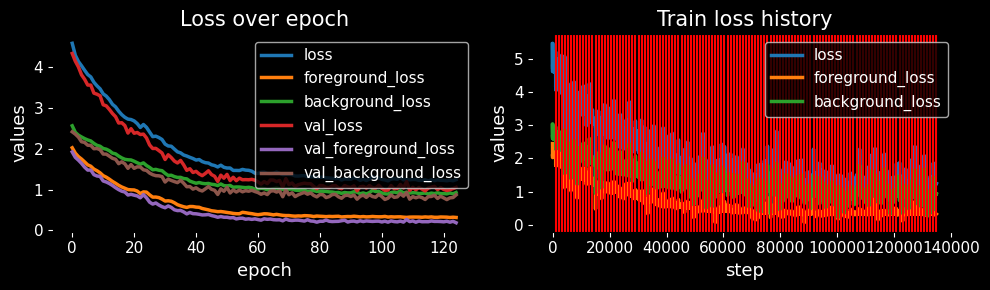

===== History =====
         loss  foreground_loss  background_loss  val_loss  val_foreground_loss  val_background_loss
0    4.593620         2.026758         2.566860  4.343271             1.923926             2.419345
1    4.299695         1.894030         2.405661  4.154089             1.791262             2.362827
2    4.146029         1.809296         2.336735  4.013322             1.723188             2.290135
3    4.042574         1.750025         2.292548  3.819448             1.643840             2.175608
4    3.931566         1.679666         2.251900  3.709805             1.551621             2.158183
..        ...              ...              ...       ...                  ...                  ...
120  1.225282         0.324413         0.900869  1.001951             0.207364             0.794587
121  1.216761         0.322313         0.894447  0.976097             0.221970             0.754127
122  1.230374         0.313913         0.916462  0.995057             0.198562  

In [4]:
model.plot_history()
print(model.history)

In [ ]:
show_memory()

## Evaluation

In [5]:
model.max_size   = (None, None)
model.max_frames = -1

for idx, row in dataset.iloc[:1].iterrows():
    image, target = model.encode_data(row)
    image  = tf.expand_dims(image, axis = 0)
    target = tf.sparse.expand_dims(target, axis = 0)
    pred   = model.infer(image, 64)
    
    print('Image shape : {} - Mask shape : {} - Output shape : {}'.format(image.shape, target.shape, pred.shape))

2023-05-15 09:20:11.324760: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


Image shape : (1, 249, 188, 213, 1) - Mask shape : (1, 249, 188, 213, 104) - Output shape : (1, 249, 188, 213, 32)


## Tests

### Test prediction

In [5]:
model.load_checkpoint(directory = model_name[:-2])

Loading checkpoint pretrained_models/cluster_unet_cosine/saving/ckpt-161


In [ ]:
if 'highres' in model_name:
    image_size   = 512 - 64
    model.max_size     = (image_size, image_size)
    model.max_frames   = 32
elif 'lowres' in model_name:
    image_size   = 128
    model.max_size     = (image_size, image_size)
    model.max_frames   = 128
else:
    image_size   = 256
    model.max_size     = (image_size, image_size)
    model.max_frames   = 32

model.pad_value = 0.
print(model.max_size, model.max_frames)
config = model.get_dataset_config(is_validation = False, batch_size = 0, shuffle_size = 0)

set_level('debug', 'datasets')

ds = prepare_dataset(train.iloc[:1], ** config)

set_level('info', 'datasets')

model.get_loss().skip_empty_frames.assign(True)
model.get_loss().skip_empty_labels.assign(True)

for inp, out in ds:
    print('Input shape : {} - output shape : {}'.format(inp.shape, out.shape))
    #plot_mask(inp[..., 0], out, n = 4)
    pred = model(tf.expand_dims(inp, axis = 0))[0]
    intersect = tf.cast(out, tf.float32) * pred
    print(model.get_loss()(tf.sparse.expand_dims(out, 0), pred[tf.newaxis]))
    print(tf.sparse.reduce_sum(intersect) / len(intersect.indices))
    print(intersect)
    plot_mask(inp[..., 0], tf.cast(pred > 0.01, tf.uint8), n = 4)
    
    

In [ ]:
mask   = (pred.numpy() > 0.1).astype(np.uint8)
labels = np.argmax(mask[..., 1:], axis = -1) + 1
voxels = np.any(mask[..., 1:], axis = -1)

organs = model.labels

show_organs = [o for o in organs if (o is not None) and ('rib' in o or 'vertebr' in o )]

skip_indexes = [i for i, organ in enumerate(organs) if organ not in show_organs]

#voxels[np.any(mask[..., skip_indexes], axis = -1)] = 0
#labels[np.any(mask[..., skip_indexes], axis = -1)] = 0


In [ ]:
print(np.any(mask, axis = -1).sum())
print(skip_indexes)
print(voxels.sum())

In [ ]:
from utils import plot_utils

importlib.reload(plot_utils)

import matplotlib.pyplot as plt

from loggers import set_level

set_level('debug', 'utils.plot_utils')

def add_color_axis(labels, cmap = None):
    mapper = plt.cm.ScalarMappable(cmap = cmap)
    return np.reshape(mapper.to_rgba(np.reshape(labels, [-1]).tolist()), list(labels.shape) + [4])

sx, sy, sz = -3, 3, 1

plot_utils.plot(
    voxels[::sy, ::sx, ::sz].astype(bool),
    figsize    = (10, 10),
    facecolors = add_color_axis(labels[::sy, ::sx, ::sz], cmap = 'magma'),
    plot_type  = 'voxels',
    color      = None,
    is_3d      = True,
    with_legend = True,
    with_colorbar = True
)

### Test dataset performances

In [ ]:
from loggers import set_level

model.max_frames = 16
model.max_size   = (512, 512)
model.labels = list(sorted(model.labels))

set_level('debug', 'datasets')

config = model.get_dataset_config(is_validation = True, batch_size = 1, cache = False, prefetch = False, shuffle_size = 0)

ds_train = prepare_dataset(train.sample(10), ** config)

set_level('info', 'datasets')

test_dataset_time(ds_train, steps = 5)

### Dataset visualization

In [ ]:
if 'highres' in model_name:
    image_size   = 512 - 64
    model.max_size     = (image_size, image_size)
    model.max_frames   = 32
elif 'lowres' in model_name:
    image_size   = 128
    model.max_size     = (image_size, image_size)
    model.max_frames   = 128
else:
    image_size   = 256
    model.max_size     = (image_size, image_size)
    model.max_frames   = 32

model.pad_value = 0.
print(model.max_size, model.max_frames)
config = model.get_dataset_config(is_validation = False, batch_size = 0, shuffle_size = 0)

set_level('debug', 'datasets')

ds = prepare_dataset(train.iloc[:5], ** config)

set_level('info', 'datasets')

for inp, out in ds:
    print('Input shape : {} - output shape : {}'.format(inp.shape, out.shape))
    plot_mask(inp[..., 0], out, n = 4)
    
    

### Test processing functions

In [ ]:
from tqdm import tqdm

n = 5
model.max_frames = 32
model.max_size   = (512, 512, 32)

for _, row in train.sample(n, random_state = 0).iterrows():
    inp, _ = model.get_input(row, False)
    print('Input shape : {} - {}'.format(inp.shape, inp.dtype))
    print("Original   : {} - {}".format(tf.reduce_min(inp), tf.reduce_max(inp)))
    inp = model.normalize_image(inp)
    print("Normalized : {} - {}".format(tf.reduce_min(inp), tf.reduce_max(inp)))
    inp = model.augment_input(inp)
    print("Augmented  : {} - {}".format(tf.reduce_min(inp), tf.reduce_max(inp)))


for _, row in train.sample(n, random_state = 0).iterrows():
    out = model.get_output_fn(row['segmentation'], row['label'])
    print('Output shape : {} - {} - type : {}'.format(out.shape, out.dtype, out.__class__.__name__))

for _, row in tqdm(train.sample(n, random_state = 0).iterrows()):
    inp, out = model.encode_data(row)
    print('Input shape : {} - output shape : {}'.format(inp.shape, out.shape))

In [ ]:
from loggers import set_level

model.max_frames = 1
model.max_size   = (256, 256)

set_level('debug', 'datasets')

config = model.get_dataset_config(is_validation = True, batch_size = 0, cache = False, prefetch = False, shuffle_size = 0)

ds_train = prepare_dataset(train, ** config)

set_level('info', 'datasets')

for i, (inp, out) in enumerate(ds_train):
    print('Batch #{} : input shape = {} - output shape = {}'.format(i, inp.shape, out.shape))
    tf.sparse.to_dense(out)


In [ ]:
print(model.voxel_dims)

img, vox_dims = load_medical_image(train.loc[0, 'images'], target_voxel_dims = model.voxel_dims)
print(img.shape)

inp = model.get_input(train.loc[0], reshape = False)
print(inp.shape)

### Configure `learning-rate scheduler`

This cell allows you to play with `learning_rate scheduler`'s parameters to get the one you want !

In [ ]:
lr = model.model_optimizer.learning_rate
lr.factor = 1024.
lr.warmup_steps = 1024
lr.plot(512 * 15)